In [14]:
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
#import submitit
import os
from pathlib import Path


def train_resnet(learning_rate, epochs, max_batches, seed, filename_prefix):
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torchvision
    import torchvision.transforms as transforms
    import torch.backends.cudnn as cudnn

    # Function to extract weights from residual blocks
    def get_residual_block_weights(model):
        block_weights = []
        current_block = []

        for name, param in model.named_parameters():
            if 'layer' in name and 'conv' in name and 'weight' in name:
                current_block.append((name, param))

                # When we have collected weights for a block
                if len(current_block) == 2:  # 2 conv layers
                    block_weights.append(current_block)
                    current_block = []

        return block_weights

    def compute_block_differences(block_weights, block_index=0):
      # Check if block_index is valid
      if block_index >= len(block_weights):
        raise ValueError(f"block_index {block_index} is too large, there are only {len(block_weights)} blocks")

      # Select only the specified block
      block = block_weights[block_index]

      # Extract conv weights from the selected block
      conv1_weight = block[0][1]  # First conv layer weights
      conv2_weight = block[1][1]  # Second conv layer weights

      # Reshape weights to matrices
      U_i = conv1_weight.view(conv1_weight.size(0), -1)
      U_i_plus_1 = conv2_weight.view(conv2_weight.size(0), -1)

      # Compute difference between squared Frobenius norms
      matrix_diff = (torch.norm(U_i)**2).item() - (torch.norm(U_i_plus_1)**2).item()

      return [matrix_diff]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move CUDA initialization inside the function
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        # submitit error
        cudnn.deterministic = True
        cudnn.benchmark = False
    # Set other random seeds
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Data preprocessing and loading
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                            shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1024,
                                             shuffle=False, num_workers=2)

    # Initialize model
    seed_weight_init = 41
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_weight_init)
    torch.manual_seed(seed_weight_init)
    np.random.seed(seed_weight_init)
    model = resnet18(num_classes=10).to(device)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.0, weight_decay=0.0)

    # Training loop with history tracking
    differences_history = []
    loss_history = []
    #accuracy_history = []
    batch_count = 0

    # Get a fixed test batch for consistent evaluation
    # and faster evaluation on just 1K samples
    eval_inputs, eval_labels = next(iter(testloader))
    eval_inputs, eval_labels = eval_inputs.to(device), eval_labels.to(device)

    # Compute and save initial differences
    block_weights = get_residual_block_weights(model)
    conserved_functions = compute_block_differences(block_weights)
    differences_history.append(conserved_functions)

    # Compute initial loss before training
    model.eval()
    initial_loss = 0.0
    n_batches_for_loss = 10
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            initial_loss += loss.item()
            if i >= n_batches_for_loss:
                break
    initial_loss /= n_batches_for_loss
    loss_history.append(initial_loss)
    print(f'Initial loss before training: {initial_loss:.3f}')
    model.train()

    for epoch in tqdm(range(epochs)):
        model.train()
      #  epoch_loss = 0.0

        for i, (inputs, labels) in tqdm(enumerate(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_count += 1

            # Store metrics every 1 batches
            if batch_count % 1 == 0:
                # Compute differences for residual blocks
                block_weights = get_residual_block_weights(model)
                conserved_functions = compute_block_differences(block_weights)
                differences_history.append(conserved_functions)
                loss_history.append(loss.item())

            if batch_count >= max_batches:
                break

        print(f'Epoch {epoch + 1} completed')

    # Save results
    results = {
        'learning_rate': learning_rate,
        'seed': seed,
        'differences_history': differences_history,
        'loss_history': loss_history,
       # 'accuracy_history': accuracy_history
    }

    save_dir = Path('results')
    save_dir.mkdir(exist_ok=True)
    torch.save(results, save_dir / f'{filename_prefix}_resnet_results_lr_{learning_rate}_seed_{seed}.pt')

    return results

if __name__ == "__main__":

    # Define learning rates and seeds to test
    learning_rates = [1e-3, 3e-3, 5e-3]
    seeds = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]  # Add more seeds as needed

    for seed in seeds:
        for lr in learning_rates:
            epoch = 1
            max_batches = 50
            train_resnet(lr, epoch, max_batches, seed, filename_prefix="6h")

Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.565


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.88s/it]
2it [00:03,  1.81s/it]
3it [00:05,  1.66s/it]
4it [00:06,  1.48s/it]
5it [00:07,  1.38s/it]
6it [00:08,  1.32s/it]
7it [00:09,  1.30s/it]
8it [00:11,  1.27s/it]
9it [00:12,  1.25s/it]
10it [00:13,  1.24s/it]
11it [00:14,  1.28s/it]
12it [00:16,  1.41s/it]
13it [00:18,  1.44s/it]
14it [00:19,  1.37s/it]
15it [00:20,  1.32s/it]
16it [00:21,  1.29s/it]
17it [00:23,  1.26s/it]
18it [00:24,  1.24s/it]
19it [00:25,  1.24s/it]
20it [00:26,  1.25s/it]
21it [00:28,  1.27s/it]
22it [00:29,  1.40s/it]
23it [00:31,  1.46s/it]
24it [00:32,  1.39s/it]
25it [00:33,  1.34s/it]
26it [00:35,  1.30s/it]
27it [00:36,  1.27s/it]
28it [00:37,  1.26s/it]
29it [00:38,  1.25s/it]
30it [00:39,  1.26s/it]
31it [00:41,  1.26s/it]
32it [00:43,  1.42s/it]
33it [00:44,  1.50s/it]
34it [00:45,  1.42s/it]
35it [00:47,  1.36s/it]
36it [00:48,  1.32s/it]
37it [00:49,  1.30s/it]
38it [00:50,  1.28s/it]
39it [00:52,  1.26s/it]
40it [00:53,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.565


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.59s/it]
2it [00:02,  1.37s/it]
3it [00:04,  1.30s/it]
4it [00:05,  1.27s/it]
5it [00:06,  1.40s/it]
6it [00:08,  1.54s/it]
7it [00:09,  1.46s/it]
8it [00:11,  1.39s/it]
9it [00:12,  1.33s/it]
10it [00:13,  1.30s/it]
11it [00:14,  1.27s/it]
12it [00:16,  1.25s/it]
13it [00:17,  1.24s/it]
14it [00:18,  1.23s/it]
15it [00:20,  1.33s/it]
16it [00:21,  1.51s/it]
17it [00:23,  1.43s/it]
18it [00:24,  1.37s/it]
19it [00:25,  1.34s/it]
20it [00:26,  1.31s/it]
21it [00:28,  1.28s/it]
22it [00:29,  1.27s/it]
23it [00:30,  1.25s/it]
24it [00:31,  1.25s/it]
25it [00:33,  1.39s/it]
26it [00:35,  1.49s/it]
27it [00:36,  1.41s/it]
28it [00:37,  1.35s/it]
29it [00:38,  1.31s/it]
30it [00:40,  1.29s/it]
31it [00:41,  1.27s/it]
32it [00:42,  1.27s/it]
33it [00:43,  1.26s/it]
34it [00:45,  1.25s/it]
35it [00:46,  1.37s/it]
36it [00:48,  1.48s/it]
37it [00:49,  1.40s/it]
38it [00:51,  1.35s/it]
39it [00:52,  1.31s/it]
40it [00:53,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.565


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.64s/it]
2it [00:02,  1.41s/it]
3it [00:04,  1.33s/it]
4it [00:05,  1.31s/it]
5it [00:06,  1.27s/it]
6it [00:07,  1.25s/it]
7it [00:09,  1.25s/it]
8it [00:10,  1.47s/it]
9it [00:13,  1.79s/it]
10it [00:15,  1.78s/it]
11it [00:16,  1.68s/it]
12it [00:18,  1.70s/it]
13it [00:19,  1.62s/it]
14it [00:21,  1.50s/it]
15it [00:22,  1.42s/it]
16it [00:23,  1.36s/it]
17it [00:25,  1.40s/it]
18it [00:26,  1.52s/it]
19it [00:28,  1.51s/it]
20it [00:29,  1.44s/it]
21it [00:30,  1.37s/it]
22it [00:32,  1.33s/it]
23it [00:33,  1.30s/it]
24it [00:34,  1.27s/it]
25it [00:35,  1.25s/it]
26it [00:36,  1.25s/it]
27it [00:38,  1.33s/it]
28it [00:40,  1.47s/it]
29it [00:41,  1.47s/it]
30it [00:42,  1.40s/it]
31it [00:44,  1.35s/it]
32it [00:45,  1.31s/it]
33it [00:46,  1.29s/it]
34it [00:47,  1.27s/it]
35it [00:49,  1.26s/it]
36it [00:50,  1.26s/it]
37it [00:51,  1.33s/it]
38it [00:53,  1.50s/it]
39it [00:55,  1.48s/it]
40it [00:56,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.574


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:02,  2.32s/it]
2it [00:03,  1.88s/it]
3it [00:05,  1.59s/it]
4it [00:06,  1.45s/it]
5it [00:07,  1.37s/it]
6it [00:08,  1.33s/it]
7it [00:10,  1.31s/it]
8it [00:11,  1.29s/it]
9it [00:12,  1.27s/it]
10it [00:14,  1.33s/it]
11it [00:15,  1.48s/it]
12it [00:17,  1.49s/it]
13it [00:18,  1.41s/it]
14it [00:19,  1.36s/it]
15it [00:21,  1.34s/it]
16it [00:22,  1.30s/it]
17it [00:23,  1.30s/it]
18it [00:24,  1.28s/it]
19it [00:26,  1.27s/it]
20it [00:27,  1.37s/it]
21it [00:29,  1.54s/it]
22it [00:30,  1.47s/it]
23it [00:32,  1.40s/it]
24it [00:33,  1.37s/it]
25it [00:34,  1.34s/it]
26it [00:36,  1.33s/it]
27it [00:37,  1.35s/it]
28it [00:38,  1.37s/it]
29it [00:40,  1.39s/it]
30it [00:42,  1.51s/it]
31it [00:43,  1.54s/it]
32it [00:45,  1.46s/it]
33it [00:46,  1.39s/it]
34it [00:47,  1.34s/it]
35it [00:48,  1.31s/it]
36it [00:49,  1.29s/it]
37it [00:51,  1.28s/it]
38it [00:52,  1.27s/it]
39it [00:54,  1.36s/it]
40it [00:55,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.574


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.60s/it]
2it [00:03,  1.50s/it]
3it [00:04,  1.68s/it]
4it [00:06,  1.63s/it]
5it [00:07,  1.49s/it]
6it [00:08,  1.42s/it]
7it [00:10,  1.36s/it]
8it [00:11,  1.32s/it]
9it [00:12,  1.29s/it]
10it [00:13,  1.26s/it]
11it [00:15,  1.25s/it]
12it [00:16,  1.34s/it]
13it [00:18,  1.46s/it]
14it [00:19,  1.47s/it]
15it [00:21,  1.41s/it]
16it [00:22,  1.36s/it]
17it [00:23,  1.33s/it]
18it [00:24,  1.30s/it]
19it [00:26,  1.29s/it]
20it [00:27,  1.27s/it]
21it [00:28,  1.26s/it]
22it [00:30,  1.34s/it]
23it [00:32,  1.50s/it]
24it [00:33,  1.48s/it]
25it [00:34,  1.41s/it]
26it [00:35,  1.36s/it]
27it [00:37,  1.33s/it]
28it [00:38,  1.30s/it]
29it [00:39,  1.29s/it]
30it [00:40,  1.27s/it]
31it [00:42,  1.26s/it]
32it [00:43,  1.37s/it]
33it [00:45,  1.53s/it]
34it [00:46,  1.45s/it]
35it [00:48,  1.38s/it]
36it [00:49,  1.33s/it]
37it [00:50,  1.30s/it]
38it [00:51,  1.28s/it]
39it [00:53,  1.28s/it]
40it [00:54,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.574


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.59s/it]
2it [00:02,  1.38s/it]
3it [00:04,  1.32s/it]
4it [00:05,  1.29s/it]
5it [00:06,  1.32s/it]
6it [00:08,  1.46s/it]
7it [00:10,  1.51s/it]
8it [00:11,  1.42s/it]
9it [00:12,  1.37s/it]
10it [00:13,  1.33s/it]
11it [00:14,  1.30s/it]
12it [00:16,  1.28s/it]
13it [00:17,  1.27s/it]
14it [00:18,  1.27s/it]
15it [00:20,  1.33s/it]
16it [00:22,  1.49s/it]
17it [00:23,  1.50s/it]
18it [00:24,  1.41s/it]
19it [00:26,  1.36s/it]
20it [00:27,  1.32s/it]
21it [00:28,  1.29s/it]
22it [00:29,  1.27s/it]
23it [00:30,  1.25s/it]
24it [00:32,  1.24s/it]
25it [00:33,  1.30s/it]
26it [00:35,  1.46s/it]
27it [00:36,  1.48s/it]
28it [00:38,  1.40s/it]
29it [00:39,  1.35s/it]
30it [00:40,  1.32s/it]
31it [00:41,  1.29s/it]
32it [00:43,  1.27s/it]
33it [00:44,  1.26s/it]
34it [00:45,  1.25s/it]
35it [00:47,  1.32s/it]
36it [00:48,  1.47s/it]
37it [00:50,  1.46s/it]
38it [00:51,  1.40s/it]
39it [00:52,  1.34s/it]
40it [00:53,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.560


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.70s/it]
2it [00:02,  1.46s/it]
3it [00:04,  1.37s/it]
4it [00:05,  1.35s/it]
5it [00:06,  1.32s/it]
6it [00:08,  1.29s/it]
7it [00:09,  1.27s/it]
8it [00:10,  1.33s/it]
9it [00:12,  1.46s/it]
10it [00:14,  1.47s/it]
11it [00:15,  1.40s/it]
12it [00:16,  1.36s/it]
13it [00:17,  1.32s/it]
14it [00:19,  1.31s/it]
15it [00:20,  1.30s/it]
16it [00:21,  1.28s/it]
17it [00:22,  1.27s/it]
18it [00:24,  1.35s/it]
19it [00:26,  1.47s/it]
20it [00:27,  1.49s/it]
21it [00:28,  1.42s/it]
22it [00:30,  1.37s/it]
23it [00:31,  1.33s/it]
24it [00:32,  1.31s/it]
25it [00:33,  1.28s/it]
26it [00:35,  1.27s/it]
27it [00:36,  1.27s/it]
28it [00:37,  1.37s/it]
29it [00:39,  1.50s/it]
30it [00:41,  1.46s/it]
31it [00:42,  1.40s/it]
32it [00:43,  1.35s/it]
33it [00:44,  1.32s/it]
34it [00:46,  1.30s/it]
35it [00:47,  1.29s/it]
36it [00:48,  1.28s/it]
37it [00:49,  1.28s/it]
38it [00:51,  1.41s/it]
39it [00:53,  1.53s/it]
40it [00:54,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.560


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.79s/it]
2it [00:03,  1.77s/it]
3it [00:05,  1.64s/it]
4it [00:06,  1.46s/it]
5it [00:07,  1.37s/it]
6it [00:08,  1.31s/it]
7it [00:09,  1.28s/it]
8it [00:11,  1.26s/it]
9it [00:12,  1.25s/it]
10it [00:13,  1.24s/it]
11it [00:14,  1.28s/it]
12it [00:16,  1.42s/it]
13it [00:18,  1.46s/it]
14it [00:19,  1.39s/it]
15it [00:20,  1.35s/it]
16it [00:21,  1.31s/it]
17it [00:23,  1.29s/it]
18it [00:24,  1.27s/it]
19it [00:25,  1.26s/it]
20it [00:26,  1.24s/it]
21it [00:28,  1.27s/it]
22it [00:29,  1.41s/it]
23it [00:31,  1.46s/it]
24it [00:32,  1.39s/it]
25it [00:33,  1.35s/it]
26it [00:35,  1.31s/it]
27it [00:36,  1.28s/it]
28it [00:37,  1.26s/it]
29it [00:38,  1.25s/it]
30it [00:39,  1.25s/it]
31it [00:41,  1.27s/it]
32it [00:43,  1.40s/it]
33it [00:44,  1.48s/it]
34it [00:45,  1.40s/it]
35it [00:47,  1.35s/it]
36it [00:48,  1.31s/it]
37it [00:49,  1.28s/it]
38it [00:50,  1.27s/it]
39it [00:52,  1.26s/it]
40it [00:53,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.560


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.56s/it]
2it [00:02,  1.37s/it]
3it [00:04,  1.30s/it]
4it [00:05,  1.29s/it]
5it [00:06,  1.27s/it]
6it [00:08,  1.42s/it]
7it [00:09,  1.51s/it]
8it [00:11,  1.41s/it]
9it [00:12,  1.35s/it]
10it [00:13,  1.31s/it]
11it [00:14,  1.28s/it]
12it [00:16,  1.26s/it]
13it [00:17,  1.25s/it]
14it [00:18,  1.25s/it]
15it [00:19,  1.25s/it]
16it [00:21,  1.39s/it]
17it [00:23,  1.49s/it]
18it [00:24,  1.41s/it]
19it [00:25,  1.36s/it]
20it [00:26,  1.31s/it]
21it [00:28,  1.28s/it]
22it [00:29,  1.26s/it]
23it [00:30,  1.26s/it]
24it [00:31,  1.24s/it]
25it [00:32,  1.23s/it]
26it [00:34,  1.35s/it]
27it [00:36,  1.49s/it]
28it [00:37,  1.43s/it]
29it [00:38,  1.37s/it]
30it [00:40,  1.32s/it]
31it [00:41,  1.29s/it]
32it [00:42,  1.27s/it]
33it [00:43,  1.26s/it]
34it [00:44,  1.24s/it]
35it [00:46,  1.23s/it]
36it [00:47,  1.33s/it]
37it [00:49,  1.47s/it]
38it [00:50,  1.42s/it]
39it [00:52,  1.37s/it]
40it [00:53,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.574


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:02,  2.36s/it]
2it [00:03,  1.77s/it]
3it [00:04,  1.52s/it]
4it [00:06,  1.41s/it]
5it [00:07,  1.34s/it]
6it [00:08,  1.30s/it]
7it [00:09,  1.27s/it]
8it [00:11,  1.25s/it]
9it [00:12,  1.24s/it]
10it [00:13,  1.34s/it]
11it [00:15,  1.49s/it]
12it [00:16,  1.43s/it]
13it [00:18,  1.36s/it]
14it [00:19,  1.32s/it]
15it [00:20,  1.29s/it]
16it [00:21,  1.27s/it]
17it [00:23,  1.26s/it]
18it [00:24,  1.25s/it]
19it [00:25,  1.24s/it]
20it [00:27,  1.35s/it]
21it [00:28,  1.49s/it]
22it [00:30,  1.45s/it]
23it [00:31,  1.38s/it]
24it [00:32,  1.33s/it]
25it [00:33,  1.30s/it]
26it [00:35,  1.27s/it]
27it [00:36,  1.25s/it]
28it [00:37,  1.25s/it]
29it [00:38,  1.24s/it]
30it [00:40,  1.34s/it]
31it [00:42,  1.47s/it]
32it [00:43,  1.43s/it]
33it [00:44,  1.36s/it]
34it [00:45,  1.32s/it]
35it [00:47,  1.29s/it]
36it [00:48,  1.27s/it]
37it [00:49,  1.25s/it]
38it [00:50,  1.24s/it]
39it [00:51,  1.23s/it]
40it [00:53,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.574


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.64s/it]
2it [00:02,  1.40s/it]
3it [00:04,  1.32s/it]
4it [00:05,  1.46s/it]
5it [00:07,  1.56s/it]
6it [00:08,  1.47s/it]
7it [00:10,  1.39s/it]
8it [00:11,  1.33s/it]
9it [00:12,  1.30s/it]
10it [00:13,  1.27s/it]
11it [00:14,  1.26s/it]
12it [00:16,  1.25s/it]
13it [00:17,  1.24s/it]
14it [00:19,  1.39s/it]
15it [00:20,  1.49s/it]
16it [00:22,  1.42s/it]
17it [00:23,  1.37s/it]
18it [00:24,  1.32s/it]
19it [00:25,  1.29s/it]
20it [00:26,  1.27s/it]
21it [00:28,  1.25s/it]
22it [00:29,  1.24s/it]
23it [00:30,  1.24s/it]
24it [00:32,  1.37s/it]
25it [00:34,  1.47s/it]
26it [00:35,  1.39s/it]
27it [00:36,  1.34s/it]
28it [00:37,  1.30s/it]
29it [00:38,  1.28s/it]
30it [00:40,  1.26s/it]
31it [00:41,  1.24s/it]
32it [00:42,  1.23s/it]
33it [00:43,  1.23s/it]
34it [00:45,  1.35s/it]
35it [00:47,  1.49s/it]
36it [00:48,  1.41s/it]
37it [00:49,  1.35s/it]
38it [00:50,  1.32s/it]
39it [00:52,  1.29s/it]
40it [00:53,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.574


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.56s/it]
2it [00:02,  1.36s/it]
3it [00:04,  1.31s/it]
4it [00:05,  1.27s/it]
5it [00:06,  1.25s/it]
6it [00:07,  1.25s/it]
7it [00:09,  1.30s/it]
8it [00:10,  1.46s/it]
9it [00:12,  1.48s/it]
10it [00:13,  1.40s/it]
11it [00:14,  1.35s/it]
12it [00:16,  1.32s/it]
13it [00:17,  1.29s/it]
14it [00:18,  1.28s/it]
15it [00:19,  1.26s/it]
16it [00:21,  1.25s/it]
17it [00:22,  1.31s/it]
18it [00:24,  1.44s/it]
19it [00:25,  1.46s/it]
20it [00:27,  1.40s/it]
21it [00:28,  1.35s/it]
22it [00:29,  1.31s/it]
23it [00:30,  1.29s/it]
24it [00:31,  1.27s/it]
25it [00:33,  1.27s/it]
26it [00:34,  1.25s/it]
27it [00:35,  1.29s/it]
28it [00:37,  1.42s/it]
29it [00:39,  1.50s/it]
30it [00:40,  1.43s/it]
31it [00:41,  1.37s/it]
32it [00:42,  1.32s/it]
33it [00:44,  1.30s/it]
34it [00:45,  1.28s/it]
35it [00:46,  1.27s/it]
36it [00:47,  1.25s/it]
37it [00:49,  1.31s/it]
38it [00:51,  1.46s/it]
39it [00:52,  1.49s/it]
40it [00:53,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.567


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.98s/it]
2it [00:03,  1.87s/it]
3it [00:05,  1.58s/it]
4it [00:06,  1.46s/it]
5it [00:07,  1.37s/it]
6it [00:08,  1.31s/it]
7it [00:09,  1.30s/it]
8it [00:11,  1.28s/it]
9it [00:12,  1.26s/it]
10it [00:13,  1.24s/it]
11it [00:15,  1.35s/it]
12it [00:17,  1.49s/it]
13it [00:18,  1.41s/it]
14it [00:19,  1.36s/it]
15it [00:20,  1.33s/it]
16it [00:22,  1.30s/it]
17it [00:23,  1.28s/it]
18it [00:24,  1.27s/it]
19it [00:25,  1.26s/it]
20it [00:26,  1.26s/it]
21it [00:28,  1.39s/it]
22it [00:30,  1.51s/it]
23it [00:31,  1.42s/it]
24it [00:32,  1.35s/it]
25it [00:34,  1.32s/it]
26it [00:35,  1.30s/it]
27it [00:36,  1.28s/it]
28it [00:37,  1.26s/it]
29it [00:39,  1.25s/it]
30it [00:40,  1.24s/it]
31it [00:41,  1.36s/it]
32it [00:43,  1.48s/it]
33it [00:44,  1.40s/it]
34it [00:46,  1.36s/it]
35it [00:47,  1.32s/it]
36it [00:48,  1.29s/it]
37it [00:49,  1.27s/it]
38it [00:51,  1.26s/it]
39it [00:52,  1.25s/it]
40it [00:53,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.567


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.60s/it]
2it [00:02,  1.38s/it]
3it [00:04,  1.33s/it]
4it [00:05,  1.30s/it]
5it [00:07,  1.47s/it]
6it [00:08,  1.54s/it]
7it [00:10,  1.44s/it]
8it [00:11,  1.39s/it]
9it [00:12,  1.34s/it]
10it [00:13,  1.31s/it]
11it [00:15,  1.29s/it]
12it [00:16,  1.28s/it]
13it [00:17,  1.26s/it]
14it [00:18,  1.28s/it]
15it [00:20,  1.44s/it]
16it [00:22,  1.50s/it]
17it [00:23,  1.42s/it]
18it [00:24,  1.38s/it]
19it [00:26,  1.34s/it]
20it [00:27,  1.31s/it]
21it [00:28,  1.28s/it]
22it [00:29,  1.27s/it]
23it [00:30,  1.26s/it]
24it [00:32,  1.32s/it]
25it [00:34,  1.44s/it]
26it [00:35,  1.48s/it]
27it [00:36,  1.41s/it]
28it [00:38,  1.36s/it]
29it [00:39,  1.33s/it]
30it [00:40,  1.30s/it]
31it [00:41,  1.28s/it]
32it [00:43,  1.26s/it]
33it [00:44,  1.25s/it]
34it [00:45,  1.32s/it]
35it [00:47,  1.48s/it]
36it [00:49,  1.47s/it]
37it [00:50,  1.40s/it]
38it [00:51,  1.35s/it]
39it [00:52,  1.31s/it]
40it [00:54,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.567


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.62s/it]
2it [00:02,  1.43s/it]
3it [00:04,  1.36s/it]
4it [00:05,  1.34s/it]
5it [00:06,  1.31s/it]
6it [00:08,  1.31s/it]
7it [00:09,  1.37s/it]
8it [00:11,  1.53s/it]
9it [00:12,  1.53s/it]
10it [00:14,  1.45s/it]
11it [00:15,  1.40s/it]
12it [00:16,  1.36s/it]
13it [00:18,  1.33s/it]
14it [00:19,  1.32s/it]
15it [00:20,  1.30s/it]
16it [00:21,  1.29s/it]
17it [00:23,  1.39s/it]
18it [00:25,  1.55s/it]
19it [00:26,  1.49s/it]
20it [00:28,  1.42s/it]
21it [00:29,  1.37s/it]
22it [00:30,  1.35s/it]
23it [00:31,  1.32s/it]
24it [00:33,  1.30s/it]
25it [00:34,  1.28s/it]
26it [00:35,  1.33s/it]
27it [00:37,  1.45s/it]
28it [00:39,  1.53s/it]
29it [00:40,  1.45s/it]
30it [00:41,  1.40s/it]
31it [00:43,  1.36s/it]
32it [00:44,  1.33s/it]
33it [00:45,  1.31s/it]
34it [00:46,  1.29s/it]
35it [00:48,  1.29s/it]
36it [00:49,  1.37s/it]
37it [00:51,  1.57s/it]
38it [00:53,  1.55s/it]
39it [00:54,  1.46s/it]
40it [00:55,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.577


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:02,  2.01s/it]
2it [00:03,  1.55s/it]
3it [00:04,  1.41s/it]
4it [00:05,  1.33s/it]
5it [00:06,  1.30s/it]
6it [00:08,  1.27s/it]
7it [00:09,  1.26s/it]
8it [00:10,  1.25s/it]
9it [00:12,  1.31s/it]
10it [00:13,  1.44s/it]
11it [00:15,  1.45s/it]
12it [00:16,  1.38s/it]
13it [00:17,  1.33s/it]
14it [00:18,  1.30s/it]
15it [00:20,  1.27s/it]
16it [00:21,  1.26s/it]
17it [00:22,  1.27s/it]
18it [00:23,  1.25s/it]
19it [00:25,  1.30s/it]
20it [00:26,  1.42s/it]
21it [00:28,  1.46s/it]
22it [00:29,  1.39s/it]
23it [00:30,  1.33s/it]
24it [00:32,  1.30s/it]
25it [00:33,  1.29s/it]
26it [00:34,  1.27s/it]
27it [00:35,  1.26s/it]
28it [00:37,  1.24s/it]
29it [00:38,  1.29s/it]
30it [00:40,  1.46s/it]
31it [00:41,  1.48s/it]
32it [00:43,  1.40s/it]
33it [00:44,  1.34s/it]
34it [00:45,  1.30s/it]
35it [00:46,  1.28s/it]
36it [00:47,  1.26s/it]
37it [00:49,  1.25s/it]
38it [00:50,  1.24s/it]
39it [00:51,  1.29s/it]
40it [00:53,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.577


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.61s/it]
2it [00:02,  1.38s/it]
3it [00:04,  1.41s/it]
4it [00:05,  1.52s/it]
5it [00:07,  1.55s/it]
6it [00:08,  1.45s/it]
7it [00:10,  1.37s/it]
8it [00:11,  1.32s/it]
9it [00:12,  1.29s/it]
10it [00:13,  1.28s/it]
11it [00:14,  1.26s/it]
12it [00:16,  1.25s/it]
13it [00:17,  1.34s/it]
14it [00:19,  1.46s/it]
15it [00:20,  1.47s/it]
16it [00:22,  1.40s/it]
17it [00:23,  1.35s/it]
18it [00:24,  1.32s/it]
19it [00:25,  1.29s/it]
20it [00:27,  1.27s/it]
21it [00:28,  1.26s/it]
22it [00:29,  1.26s/it]
23it [00:31,  1.33s/it]
24it [00:32,  1.48s/it]
25it [00:34,  1.50s/it]
26it [00:35,  1.42s/it]
27it [00:36,  1.37s/it]
28it [00:38,  1.34s/it]
29it [00:39,  1.31s/it]
30it [00:40,  1.29s/it]
31it [00:41,  1.28s/it]
32it [00:43,  1.26s/it]
33it [00:44,  1.35s/it]
34it [00:46,  1.50s/it]
35it [00:47,  1.46s/it]
36it [00:49,  1.40s/it]
37it [00:50,  1.35s/it]
38it [00:51,  1.32s/it]
39it [00:52,  1.30s/it]
40it [00:54,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.577


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.59s/it]
2it [00:02,  1.38s/it]
3it [00:04,  1.32s/it]
4it [00:05,  1.28s/it]
5it [00:06,  1.27s/it]
6it [00:07,  1.29s/it]
7it [00:09,  1.42s/it]
8it [00:11,  1.46s/it]
9it [00:12,  1.40s/it]
10it [00:13,  1.35s/it]
11it [00:14,  1.30s/it]
12it [00:16,  1.29s/it]
13it [00:17,  1.27s/it]
14it [00:18,  1.27s/it]
15it [00:19,  1.25s/it]
16it [00:21,  1.26s/it]
17it [00:22,  1.39s/it]
18it [00:24,  1.48s/it]
19it [00:25,  1.40s/it]
20it [00:26,  1.34s/it]
21it [00:28,  1.30s/it]
22it [00:29,  1.28s/it]
23it [00:30,  1.26s/it]
24it [00:31,  1.25s/it]
25it [00:32,  1.24s/it]
26it [00:34,  1.24s/it]
27it [00:35,  1.37s/it]
28it [00:37,  1.48s/it]
29it [00:38,  1.40s/it]
30it [00:40,  1.34s/it]
31it [00:41,  1.31s/it]
32it [00:42,  1.28s/it]
33it [00:43,  1.26s/it]
34it [00:44,  1.24s/it]
35it [00:46,  1.23s/it]
36it [00:47,  1.23s/it]
37it [00:48,  1.35s/it]
38it [00:50,  1.48s/it]
39it [00:51,  1.41s/it]
40it [00:53,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.571


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:02,  2.11s/it]
2it [00:03,  1.90s/it]
3it [00:05,  1.60s/it]
4it [00:06,  1.46s/it]
5it [00:07,  1.38s/it]
6it [00:08,  1.32s/it]
7it [00:10,  1.31s/it]
8it [00:11,  1.29s/it]
9it [00:12,  1.27s/it]
10it [00:13,  1.32s/it]
11it [00:15,  1.48s/it]
12it [00:17,  1.50s/it]
13it [00:18,  1.43s/it]
14it [00:19,  1.37s/it]
15it [00:21,  1.34s/it]
16it [00:22,  1.31s/it]
17it [00:23,  1.28s/it]
18it [00:24,  1.27s/it]
19it [00:26,  1.26s/it]
20it [00:27,  1.31s/it]
21it [00:29,  1.44s/it]
22it [00:30,  1.46s/it]
23it [00:31,  1.40s/it]
24it [00:33,  1.35s/it]
25it [00:34,  1.31s/it]
26it [00:35,  1.29s/it]
27it [00:36,  1.27s/it]
28it [00:38,  1.27s/it]
29it [00:39,  1.27s/it]
30it [00:40,  1.32s/it]
31it [00:42,  1.45s/it]
32it [00:44,  1.46s/it]
33it [00:45,  1.39s/it]
34it [00:46,  1.35s/it]
35it [00:47,  1.35s/it]
36it [00:49,  1.33s/it]
37it [00:50,  1.32s/it]
38it [00:51,  1.31s/it]
39it [00:53,  1.31s/it]
40it [00:54,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.571


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.68s/it]
2it [00:02,  1.44s/it]
3it [00:04,  1.50s/it]
4it [00:06,  1.67s/it]
5it [00:08,  1.63s/it]
6it [00:09,  1.51s/it]
7it [00:10,  1.43s/it]
8it [00:11,  1.38s/it]
9it [00:13,  1.36s/it]
10it [00:14,  1.34s/it]
11it [00:15,  1.31s/it]
12it [00:16,  1.29s/it]
13it [00:18,  1.39s/it]
14it [00:20,  1.55s/it]
15it [00:21,  1.46s/it]
16it [00:23,  1.41s/it]
17it [00:24,  1.36s/it]
18it [00:25,  1.32s/it]
19it [00:26,  1.29s/it]
20it [00:27,  1.27s/it]
21it [00:29,  1.26s/it]
22it [00:30,  1.25s/it]
23it [00:32,  1.40s/it]
24it [00:33,  1.50s/it]
25it [00:35,  1.42s/it]
26it [00:36,  1.36s/it]
27it [00:37,  1.33s/it]
28it [00:38,  1.30s/it]
29it [00:40,  1.29s/it]
30it [00:41,  1.28s/it]
31it [00:42,  1.27s/it]
32it [00:43,  1.26s/it]
33it [00:45,  1.40s/it]
34it [00:47,  1.48s/it]
35it [00:48,  1.41s/it]
36it [00:49,  1.36s/it]
37it [00:50,  1.32s/it]
38it [00:52,  1.29s/it]
39it [00:53,  1.29s/it]
40it [00:54,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.571


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.60s/it]
2it [00:02,  1.39s/it]
3it [00:04,  1.31s/it]
4it [00:05,  1.27s/it]
5it [00:06,  1.26s/it]
6it [00:07,  1.32s/it]
7it [00:09,  1.46s/it]
8it [00:11,  1.50s/it]
9it [00:12,  1.41s/it]
10it [00:13,  1.36s/it]
11it [00:15,  1.34s/it]
12it [00:16,  1.31s/it]
13it [00:17,  1.28s/it]
14it [00:18,  1.26s/it]
15it [00:19,  1.27s/it]
16it [00:21,  1.32s/it]
17it [00:23,  1.45s/it]
18it [00:24,  1.47s/it]
19it [00:25,  1.41s/it]
20it [00:27,  1.36s/it]
21it [00:28,  1.32s/it]
22it [00:29,  1.29s/it]
23it [00:30,  1.27s/it]
24it [00:32,  1.26s/it]
25it [00:33,  1.25s/it]
26it [00:34,  1.30s/it]
27it [00:36,  1.43s/it]
28it [00:37,  1.46s/it]
29it [00:39,  1.39s/it]
30it [00:40,  1.33s/it]
31it [00:41,  1.29s/it]
32it [00:42,  1.28s/it]
33it [00:44,  1.27s/it]
34it [00:45,  1.25s/it]
35it [00:46,  1.24s/it]
36it [00:47,  1.25s/it]
37it [00:49,  1.41s/it]
38it [00:51,  1.47s/it]
39it [00:52,  1.39s/it]
40it [00:53,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.563


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:02,  2.30s/it]
2it [00:03,  1.83s/it]
3it [00:05,  1.56s/it]
4it [00:06,  1.43s/it]
5it [00:07,  1.36s/it]
6it [00:08,  1.31s/it]
7it [00:09,  1.29s/it]
8it [00:11,  1.28s/it]
9it [00:12,  1.26s/it]
10it [00:13,  1.32s/it]
11it [00:15,  1.45s/it]
12it [00:17,  1.47s/it]
13it [00:18,  1.40s/it]
14it [00:19,  1.35s/it]
15it [00:20,  1.32s/it]
16it [00:22,  1.29s/it]
17it [00:23,  1.29s/it]
18it [00:24,  1.28s/it]
19it [00:25,  1.26s/it]
20it [00:27,  1.32s/it]
21it [00:29,  1.45s/it]
22it [00:30,  1.46s/it]
23it [00:31,  1.39s/it]
24it [00:33,  1.35s/it]
25it [00:34,  1.31s/it]
26it [00:35,  1.29s/it]
27it [00:36,  1.27s/it]
28it [00:37,  1.25s/it]
29it [00:39,  1.25s/it]
30it [00:40,  1.31s/it]
31it [00:42,  1.46s/it]
32it [00:43,  1.47s/it]
33it [00:45,  1.40s/it]
34it [00:46,  1.34s/it]
35it [00:47,  1.31s/it]
36it [00:48,  1.28s/it]
37it [00:50,  1.26s/it]
38it [00:51,  1.25s/it]
39it [00:52,  1.25s/it]
40it [00:54,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.563


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.61s/it]
2it [00:02,  1.40s/it]
3it [00:04,  1.33s/it]
4it [00:05,  1.41s/it]
5it [00:07,  1.54s/it]
6it [00:08,  1.51s/it]
7it [00:10,  1.41s/it]
8it [00:11,  1.35s/it]
9it [00:12,  1.31s/it]
10it [00:13,  1.28s/it]
11it [00:14,  1.26s/it]
12it [00:16,  1.25s/it]
13it [00:17,  1.24s/it]
14it [00:18,  1.31s/it]
15it [00:20,  1.44s/it]
16it [00:22,  1.45s/it]
17it [00:23,  1.38s/it]
18it [00:24,  1.34s/it]
19it [00:25,  1.31s/it]
20it [00:27,  1.29s/it]
21it [00:28,  1.27s/it]
22it [00:29,  1.27s/it]
23it [00:30,  1.25s/it]
24it [00:32,  1.32s/it]
25it [00:33,  1.46s/it]
26it [00:35,  1.47s/it]
27it [00:36,  1.40s/it]
28it [00:37,  1.34s/it]
29it [00:39,  1.32s/it]
30it [00:40,  1.29s/it]
31it [00:41,  1.27s/it]
32it [00:42,  1.26s/it]
33it [00:44,  1.26s/it]
34it [00:45,  1.37s/it]
35it [00:47,  1.51s/it]
36it [00:49,  1.48s/it]
37it [00:50,  1.41s/it]
38it [00:51,  1.36s/it]
39it [00:52,  1.33s/it]
40it [00:54,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.563


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.65s/it]
2it [00:02,  1.41s/it]
3it [00:04,  1.33s/it]
4it [00:05,  1.29s/it]
5it [00:06,  1.26s/it]
6it [00:07,  1.25s/it]
7it [00:09,  1.29s/it]
8it [00:10,  1.44s/it]
9it [00:12,  1.46s/it]
10it [00:13,  1.39s/it]
11it [00:14,  1.34s/it]
12it [00:16,  1.30s/it]
13it [00:17,  1.28s/it]
14it [00:18,  1.27s/it]
15it [00:19,  1.26s/it]
16it [00:21,  1.25s/it]
17it [00:22,  1.28s/it]
18it [00:24,  1.42s/it]
19it [00:25,  1.49s/it]
20it [00:26,  1.41s/it]
21it [00:28,  1.37s/it]
22it [00:29,  1.33s/it]
23it [00:30,  1.30s/it]
24it [00:31,  1.29s/it]
25it [00:33,  1.27s/it]
26it [00:34,  1.27s/it]
27it [00:35,  1.32s/it]
28it [00:37,  1.45s/it]
29it [00:39,  1.47s/it]
30it [00:40,  1.40s/it]
31it [00:41,  1.35s/it]
32it [00:42,  1.31s/it]
33it [00:44,  1.29s/it]
34it [00:45,  1.27s/it]
35it [00:46,  1.27s/it]
36it [00:47,  1.26s/it]
37it [00:49,  1.33s/it]
38it [00:51,  1.44s/it]
39it [00:52,  1.47s/it]
40it [00:53,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.574


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.96s/it]
2it [00:03,  1.90s/it]
3it [00:05,  1.64s/it]
4it [00:06,  1.49s/it]
5it [00:07,  1.39s/it]
6it [00:08,  1.34s/it]
7it [00:10,  1.30s/it]
8it [00:11,  1.28s/it]
9it [00:12,  1.27s/it]
10it [00:13,  1.25s/it]
11it [00:15,  1.37s/it]
12it [00:17,  1.52s/it]
13it [00:18,  1.43s/it]
14it [00:19,  1.38s/it]
15it [00:20,  1.33s/it]
16it [00:22,  1.30s/it]
17it [00:23,  1.28s/it]
18it [00:24,  1.27s/it]
19it [00:25,  1.27s/it]
20it [00:27,  1.25s/it]
21it [00:28,  1.37s/it]
22it [00:30,  1.49s/it]
23it [00:31,  1.41s/it]
24it [00:33,  1.36s/it]
25it [00:34,  1.33s/it]
26it [00:35,  1.30s/it]
27it [00:36,  1.28s/it]
28it [00:37,  1.26s/it]
29it [00:39,  1.26s/it]
30it [00:40,  1.24s/it]
31it [00:42,  1.39s/it]
32it [00:43,  1.48s/it]
33it [00:45,  1.40s/it]
34it [00:46,  1.35s/it]
35it [00:47,  1.31s/it]
36it [00:48,  1.29s/it]
37it [00:49,  1.27s/it]
38it [00:51,  1.26s/it]
39it [00:52,  1.25s/it]
40it [00:53,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.574


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.66s/it]
2it [00:02,  1.42s/it]
3it [00:04,  1.33s/it]
4it [00:05,  1.32s/it]
5it [00:07,  1.47s/it]
6it [00:08,  1.52s/it]
7it [00:10,  1.42s/it]
8it [00:11,  1.37s/it]
9it [00:12,  1.33s/it]
10it [00:13,  1.30s/it]
11it [00:15,  1.29s/it]
12it [00:16,  1.28s/it]
13it [00:17,  1.26s/it]
14it [00:18,  1.27s/it]
15it [00:20,  1.42s/it]
16it [00:22,  1.50s/it]
17it [00:23,  1.42s/it]
18it [00:24,  1.39s/it]
19it [00:26,  1.34s/it]
20it [00:27,  1.31s/it]
21it [00:28,  1.28s/it]
22it [00:29,  1.26s/it]
23it [00:30,  1.25s/it]
24it [00:32,  1.28s/it]
25it [00:34,  1.42s/it]
26it [00:35,  1.48s/it]
27it [00:36,  1.40s/it]
28it [00:38,  1.35s/it]
29it [00:39,  1.32s/it]
30it [00:40,  1.29s/it]
31it [00:41,  1.27s/it]
32it [00:43,  1.26s/it]
33it [00:44,  1.25s/it]
34it [00:45,  1.29s/it]
35it [00:47,  1.42s/it]
36it [00:48,  1.48s/it]
37it [00:50,  1.41s/it]
38it [00:51,  1.35s/it]
39it [00:52,  1.31s/it]
40it [00:53,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.574


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.62s/it]
2it [00:02,  1.39s/it]
3it [00:04,  1.31s/it]
4it [00:05,  1.28s/it]
5it [00:06,  1.27s/it]
6it [00:07,  1.26s/it]
7it [00:09,  1.26s/it]
8it [00:10,  1.38s/it]
9it [00:12,  1.50s/it]
10it [00:13,  1.46s/it]
11it [00:15,  1.39s/it]
12it [00:16,  1.34s/it]
13it [00:17,  1.30s/it]
14it [00:18,  1.28s/it]
15it [00:19,  1.27s/it]
16it [00:21,  1.26s/it]
17it [00:22,  1.25s/it]
18it [00:24,  1.36s/it]
19it [00:25,  1.49s/it]
20it [00:27,  1.44s/it]
21it [00:28,  1.38s/it]
22it [00:29,  1.34s/it]
23it [00:30,  1.30s/it]
24it [00:32,  1.28s/it]
25it [00:33,  1.27s/it]
26it [00:34,  1.27s/it]
27it [00:35,  1.26s/it]
28it [00:37,  1.37s/it]
29it [00:39,  1.51s/it]
30it [00:40,  1.45s/it]
31it [00:41,  1.39s/it]
32it [00:43,  1.36s/it]
33it [00:44,  1.33s/it]
34it [00:45,  1.32s/it]
35it [00:46,  1.30s/it]
36it [00:48,  1.28s/it]
37it [00:49,  1.26s/it]
38it [00:51,  1.42s/it]
39it [00:52,  1.49s/it]
40it [00:54,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.560


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:02,  2.12s/it]
2it [00:04,  1.99s/it]
3it [00:05,  1.66s/it]
4it [00:06,  1.49s/it]
5it [00:07,  1.41s/it]
6it [00:09,  1.36s/it]
7it [00:10,  1.32s/it]
8it [00:11,  1.29s/it]
9it [00:12,  1.28s/it]
10it [00:14,  1.31s/it]
11it [00:15,  1.45s/it]
12it [00:17,  1.51s/it]
13it [00:18,  1.43s/it]
14it [00:20,  1.37s/it]
15it [00:21,  1.33s/it]
16it [00:22,  1.30s/it]
17it [00:23,  1.30s/it]
18it [00:25,  1.28s/it]
19it [00:26,  1.26s/it]
20it [00:27,  1.31s/it]
21it [00:29,  1.49s/it]
22it [00:31,  1.51s/it]
23it [00:32,  1.43s/it]
24it [00:33,  1.38s/it]
25it [00:34,  1.33s/it]
26it [00:36,  1.30s/it]
27it [00:37,  1.27s/it]
28it [00:38,  1.26s/it]
29it [00:39,  1.25s/it]
30it [00:41,  1.34s/it]
31it [00:43,  1.47s/it]
32it [00:44,  1.48s/it]
33it [00:45,  1.41s/it]
34it [00:47,  1.36s/it]
35it [00:48,  1.33s/it]
36it [00:49,  1.30s/it]
37it [00:50,  1.29s/it]
38it [00:52,  1.26s/it]
39it [00:53,  1.25s/it]
40it [00:54,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.560


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.56s/it]
2it [00:02,  1.37s/it]
3it [00:04,  1.31s/it]
4it [00:05,  1.41s/it]
5it [00:07,  1.58s/it]
6it [00:08,  1.50s/it]
7it [00:10,  1.42s/it]
8it [00:11,  1.36s/it]
9it [00:12,  1.32s/it]
10it [00:13,  1.30s/it]
11it [00:15,  1.29s/it]
12it [00:16,  1.28s/it]
13it [00:17,  1.28s/it]
14it [00:19,  1.42s/it]
15it [00:21,  1.52s/it]
16it [00:22,  1.44s/it]
17it [00:23,  1.38s/it]
18it [00:24,  1.34s/it]
19it [00:26,  1.32s/it]
20it [00:27,  1.29s/it]
21it [00:28,  1.28s/it]
22it [00:29,  1.27s/it]
23it [00:31,  1.30s/it]
24it [00:32,  1.44s/it]
25it [00:34,  1.49s/it]
26it [00:35,  1.41s/it]
27it [00:37,  1.36s/it]
28it [00:38,  1.33s/it]
29it [00:39,  1.30s/it]
30it [00:40,  1.28s/it]
31it [00:41,  1.27s/it]
32it [00:43,  1.26s/it]
33it [00:44,  1.31s/it]
34it [00:46,  1.44s/it]
35it [00:48,  1.50s/it]
36it [00:49,  1.42s/it]
37it [00:50,  1.36s/it]
38it [00:51,  1.32s/it]
39it [00:52,  1.30s/it]
40it [00:54,  1.

Epoch 1 completed
Files already downloaded and verified
Files already downloaded and verified
Initial loss before training: 2.560


  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.59s/it]
2it [00:02,  1.39s/it]
3it [00:04,  1.31s/it]
4it [00:05,  1.29s/it]
5it [00:06,  1.26s/it]
6it [00:07,  1.25s/it]
7it [00:09,  1.40s/it]
8it [00:11,  1.53s/it]
9it [00:12,  1.43s/it]
10it [00:13,  1.37s/it]
11it [00:14,  1.33s/it]
12it [00:16,  1.30s/it]
13it [00:17,  1.29s/it]
14it [00:18,  1.27s/it]
15it [00:19,  1.26s/it]
16it [00:21,  1.25s/it]
17it [00:22,  1.39s/it]
18it [00:24,  1.51s/it]
19it [00:25,  1.43s/it]
20it [00:27,  1.37s/it]
21it [00:28,  1.33s/it]
22it [00:29,  1.30s/it]
23it [00:30,  1.28s/it]
24it [00:32,  1.28s/it]
25it [00:33,  1.26s/it]
26it [00:34,  1.27s/it]
27it [00:36,  1.43s/it]
28it [00:38,  1.49s/it]
29it [00:39,  1.42s/it]
30it [00:40,  1.36s/it]
31it [00:41,  1.32s/it]
32it [00:42,  1.29s/it]
33it [00:44,  1.29s/it]
34it [00:45,  1.27s/it]
35it [00:46,  1.26s/it]
36it [00:48,  1.28s/it]
37it [00:49,  1.42s/it]
38it [00:51,  1.48s/it]
39it [00:52,  1.42s/it]
40it [00:53,  1.

Epoch 1 completed


<ipython-input-21-44a74510abfe>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results = torch.load(file)


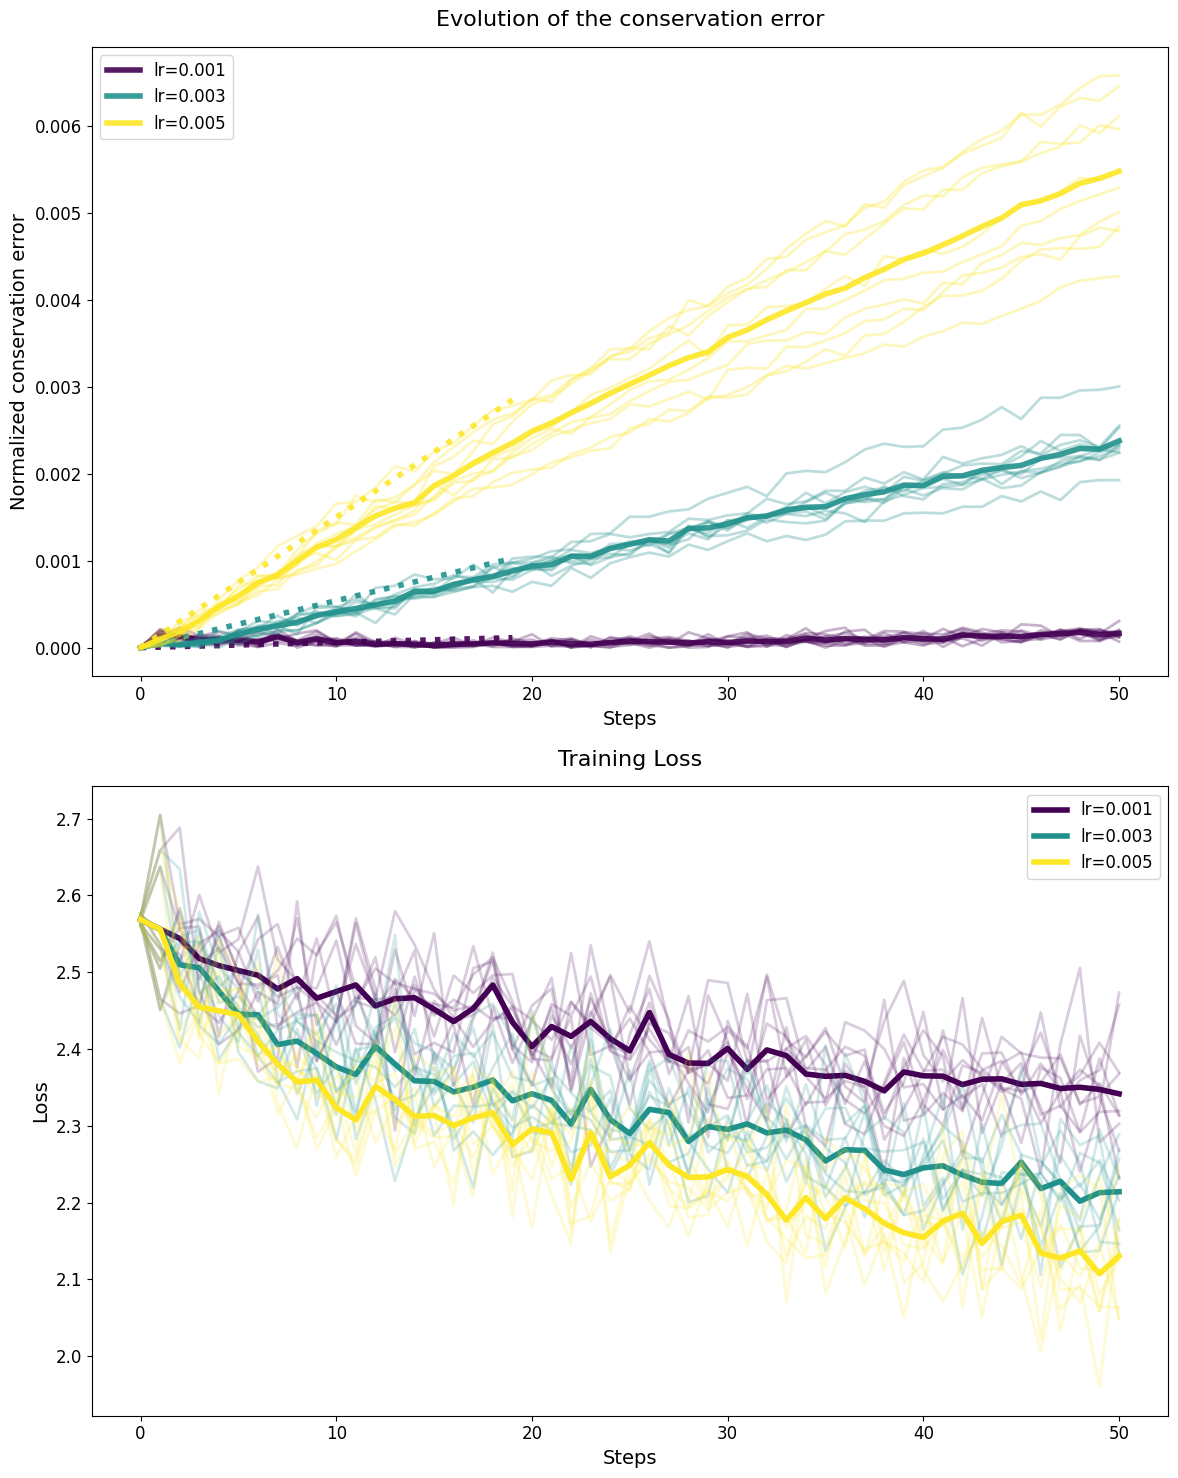

In [21]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_training_results(filename_prefix):
    # Load results for different learning rates
    save_dir = Path('results')

    # Group results by learning rate
    lr_results = {}
    for file in save_dir.glob(f'{filename_prefix}_resnet_results_lr_*.pt'):
        results = torch.load(file)
        lr = results['learning_rate']
        if lr not in lr_results:
            lr_results[lr] = []
        lr_results[lr].append(results)

    # Create two subplots with larger figure size
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 15))

    # Color map for different learning rates
    colors = plt.cm.viridis(np.linspace(0, 1, len(lr_results)))

    # Increase font sizes and line widths
    plt.rcParams.update({'font.size': 14})  # Increase base font size

    for (lr, results_list), color in zip(sorted(lr_results.items()), colors):
        if lr==0.1:
          continue
        #print("lr", lr)
        #print("results_list", results_list)
        # Calculate mean and std across seeds for each metric
        all_conserved = [r['differences_history'] for r in results_list]
        #all_accuracies = [r['accuracy_history'] for r in results_list]
        all_losses = [r['loss_history'] for r in results_list]

        # Convert to numpy arrays and ensure same length
        min_length = min(len(d) for d in all_conserved)
        all_conserved = [d[:min_length] for d in all_conserved]
        #all_accuracies = [a[:min_length] for a in all_accuracies]
        all_losses = [l[:min_length] for l in all_losses]
        #print("len(all_diffs)", len(all_conserved))

        conserved_array = np.array(all_conserved)
        #print("lr", lr)
        #print("conserved_array", conserved_array)
        #accuracies_array = np.array(all_accuracies)
        all_losses_array = np.array(all_losses)
        #print("len(accuracies_array)[0]", len(accuracies_array[0]))

        # Calculate steps (x-axis)
        steps = np.arange(min_length)
        #print("steps", steps)
        normalized_steps = steps * lr
        #print("normalized_steps", normalized_steps)

        # Normalize differences relative to initial value
        #print("conserved_array", conserved_array.shape)
        diffs = np.abs((conserved_array - conserved_array[:,0][...,np.newaxis,:]) / conserved_array[:,0][...,np.newaxis,:])
        #print("diffs", diffs)
        normalized_diffs = np.nanmean(diffs, axis=2)  # Average across features
        #print("normalized_diffs", normalized_diffs)
        normalized_diffs_mean = np.nanmean(normalized_diffs, axis=0) # Average across seeds
        #print("normalized_diffs_mean", normalized_diffs_mean)
        #print("normalized_diffs_mean", normalized_diffs_mean.shape)
        #print("normalized_steps", normalized_steps.shape)

        for i in range(normalized_diffs.shape[0]):
            ax1.plot(steps, normalized_diffs[i], '-', color=color, alpha=0.3, linewidth=2)

        # Plot mean line for differences with darker color and thicker line
        ax1.plot(steps, normalized_diffs_mean, '-', color=color,  alpha=0.9,
               label=f'lr={lr}', linewidth=4)
        #ax1.scatter(steps, normalized_diffs_mean, color=color, s=50, alpha=0.5)

        # Plot theoretical curve with thicker line
        theoretical = steps * (lr**2) * 6
        ax1.plot(steps[:20], theoretical[:20], ':', color=color, alpha=0.9, linewidth=4)

        # Plot individual losses curves with thicker lines
        for i in range(all_losses_array.shape[0]):
            ax2.plot(steps, all_losses_array[i], '-', color=color, alpha=0.2, linewidth=2)

        # Calculate mean and std for losses
        losses_mean = np.mean(all_losses_array, axis=0)
        losses_std = np.nanstd(all_losses_array, axis=0)

        #print("losses_mean", losses_mean)
        # Plot mean line for accuracies with thicker line
        ax2.plot(steps, losses_mean, '-', color=color,
                label=f'lr={lr}', linewidth=4)
        #ax2.scatter(steps, accuracies_mean, color=color, s=50, alpha=0.5)

    # Customize plots with larger text
    for ax in [ax1, ax2]:
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.legend(fontsize=12)
        ax.grid(True, linewidth=1.5)  # Thicker grid lines

    ax1.set_xlabel('Steps', fontsize=14)
    #plt.xlabel(r'$\Delta t$ (ms)')
    ax1.set_ylabel('Normalized conservation error', fontsize=14)
    ax1.grid(False)
    #ax1.set_yscale('log')
    #ax1.set_xscale('log')
    ax1.set_title('Evolution of the conservation error', fontsize=16, pad=15)

    ax2.set_xlabel('Steps', fontsize=14)
    #ax2.set_xscale('log')
    ax2.set_ylabel('Loss', fontsize=14)
    ax2.set_title('Training Loss', fontsize=16, pad=15)
    ax2.grid(False)
    plt.tight_layout()
    plt.show()
    #plt.savefig('training_analysis.png')
    #plt.close()

if __name__ == "__main__":
    # ... existing code ...

    # Add after the training jobs complete
    plot_training_results("6h")
